In [14]:
# import pkgs
%load_ext autoreload
%autoreload 2
import sys
import utils
import numpy as np
import pandas as pd
#pd.options.display.max_columns = None  # show all columns in summary/head methods
pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 100)

from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = 'darkgrid', color_codes = True)
sns.set_context("notebook", font_scale = 1.1)
plt.rcParams['savefig.dpi'] = 800
plt.rcParams['figure.figsize'] = 14, 10

import geopandas as gpd
import descartes
import gmplot
import mysql.connector
from shapely.geometry import Point, Polygon

import geopy
import math
from geopy import distance

import os
import data
import features
import models

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from importlib import reload
reload(models)

<module 'models' from 'c:\\users\\vasan.churchill\\documents\\personal\\s2ds-documents\\team-gophr\\repos\\s2ds-clean-trial\\s2ds\\src\\models\\__init__.py'>

In [3]:
# get data
#data.execute_query_and_save_df('df1_query.sql','df1.feather')
# get weather data
#data.execute_query_and_save_df('weather_query.sql','weather_df.feather')

# get cleaned DataFrame
#df = data.clean_merge_and_save('df1.feather', 'weather_df.feather', 'df_concat.feather')

# load data from data/interim
df = pd.read_feather(utils.path_to('data', 'interim', 'df_concat.feather'))
df, feature_names  = features.generate_features(df)
# remove colms with dt and NAs
#feature_names.remove('initial_time_buffer')
#feature_names.remove('delivery_zone')

Timed categorising: earliest_pickup_time
Timed categorising: delivery_deadline
Unchanged features: show_on_board, is_first_war_job, temp, feels_like, humidity, wind_speed, clouds_all, is_daytime
Engineering individual features
Log transforming: distance, initial_time_buffer, estimated_journey_time, courier_earnings_calc, size_min, size_med, size_max, weight, volume, size_min_max
Minimum of initial_time_buffer is less or equal to 0: -12839.0, adding constant of 12840.0 prior to log.
Minimum of courier_earnings_calc is less or equal to 0: -5904.46, adding constant of 5905.46 prior to log.
One hot encoding: is_food, is_fragile, is_liquid, is_not_rotatable, is_glass, is_baked, is_flower, is_alcohol, is_beef, is_pork
One hot encoding: vehicle_type, job_priority, weather_cats, earliest_pickup_time_month, earliest_pickup_time_day, earliest_pickup_time_hour, pickup_zone, delivery_zone
Cyclic encoding: earliest_pickup_time
Cyclic encoding: delivery_deadline


In [4]:
dir_name = utils.path_to('src', 'data','GB_Postcodes')
file_name = 'PostalDistrict.shp'
file_path=os.path.join(dir_name,file_name)
GB_PoD_df=gpd.read_file(file_path)

In [5]:
London_PoD_df=GB_PoD_df[GB_PoD_df['PostArea'].isin(['EC', 'WC', 'E', 'N', 'NW', 'SE', 'SW', 'W'])]

646       Annotation(534882, 181679, 'E1')
647      Annotation(537500, 187128, 'E10')
648      Annotation(539989, 187678, 'E11')
649      Annotation(542145, 185914, 'E12')
650      Annotation(540713, 182872, 'E13')
                       ...                
2617    Annotation(530552, 181199, 'WC2B')
2618    Annotation(530376, 180883, 'WC2E')
2619    Annotation(530009, 181024, 'WC2H')
2620    Annotation(530231, 180512, 'WC2N')
2621    Annotation(530739, 180814, 'WC2R')
Length: 170, dtype: object

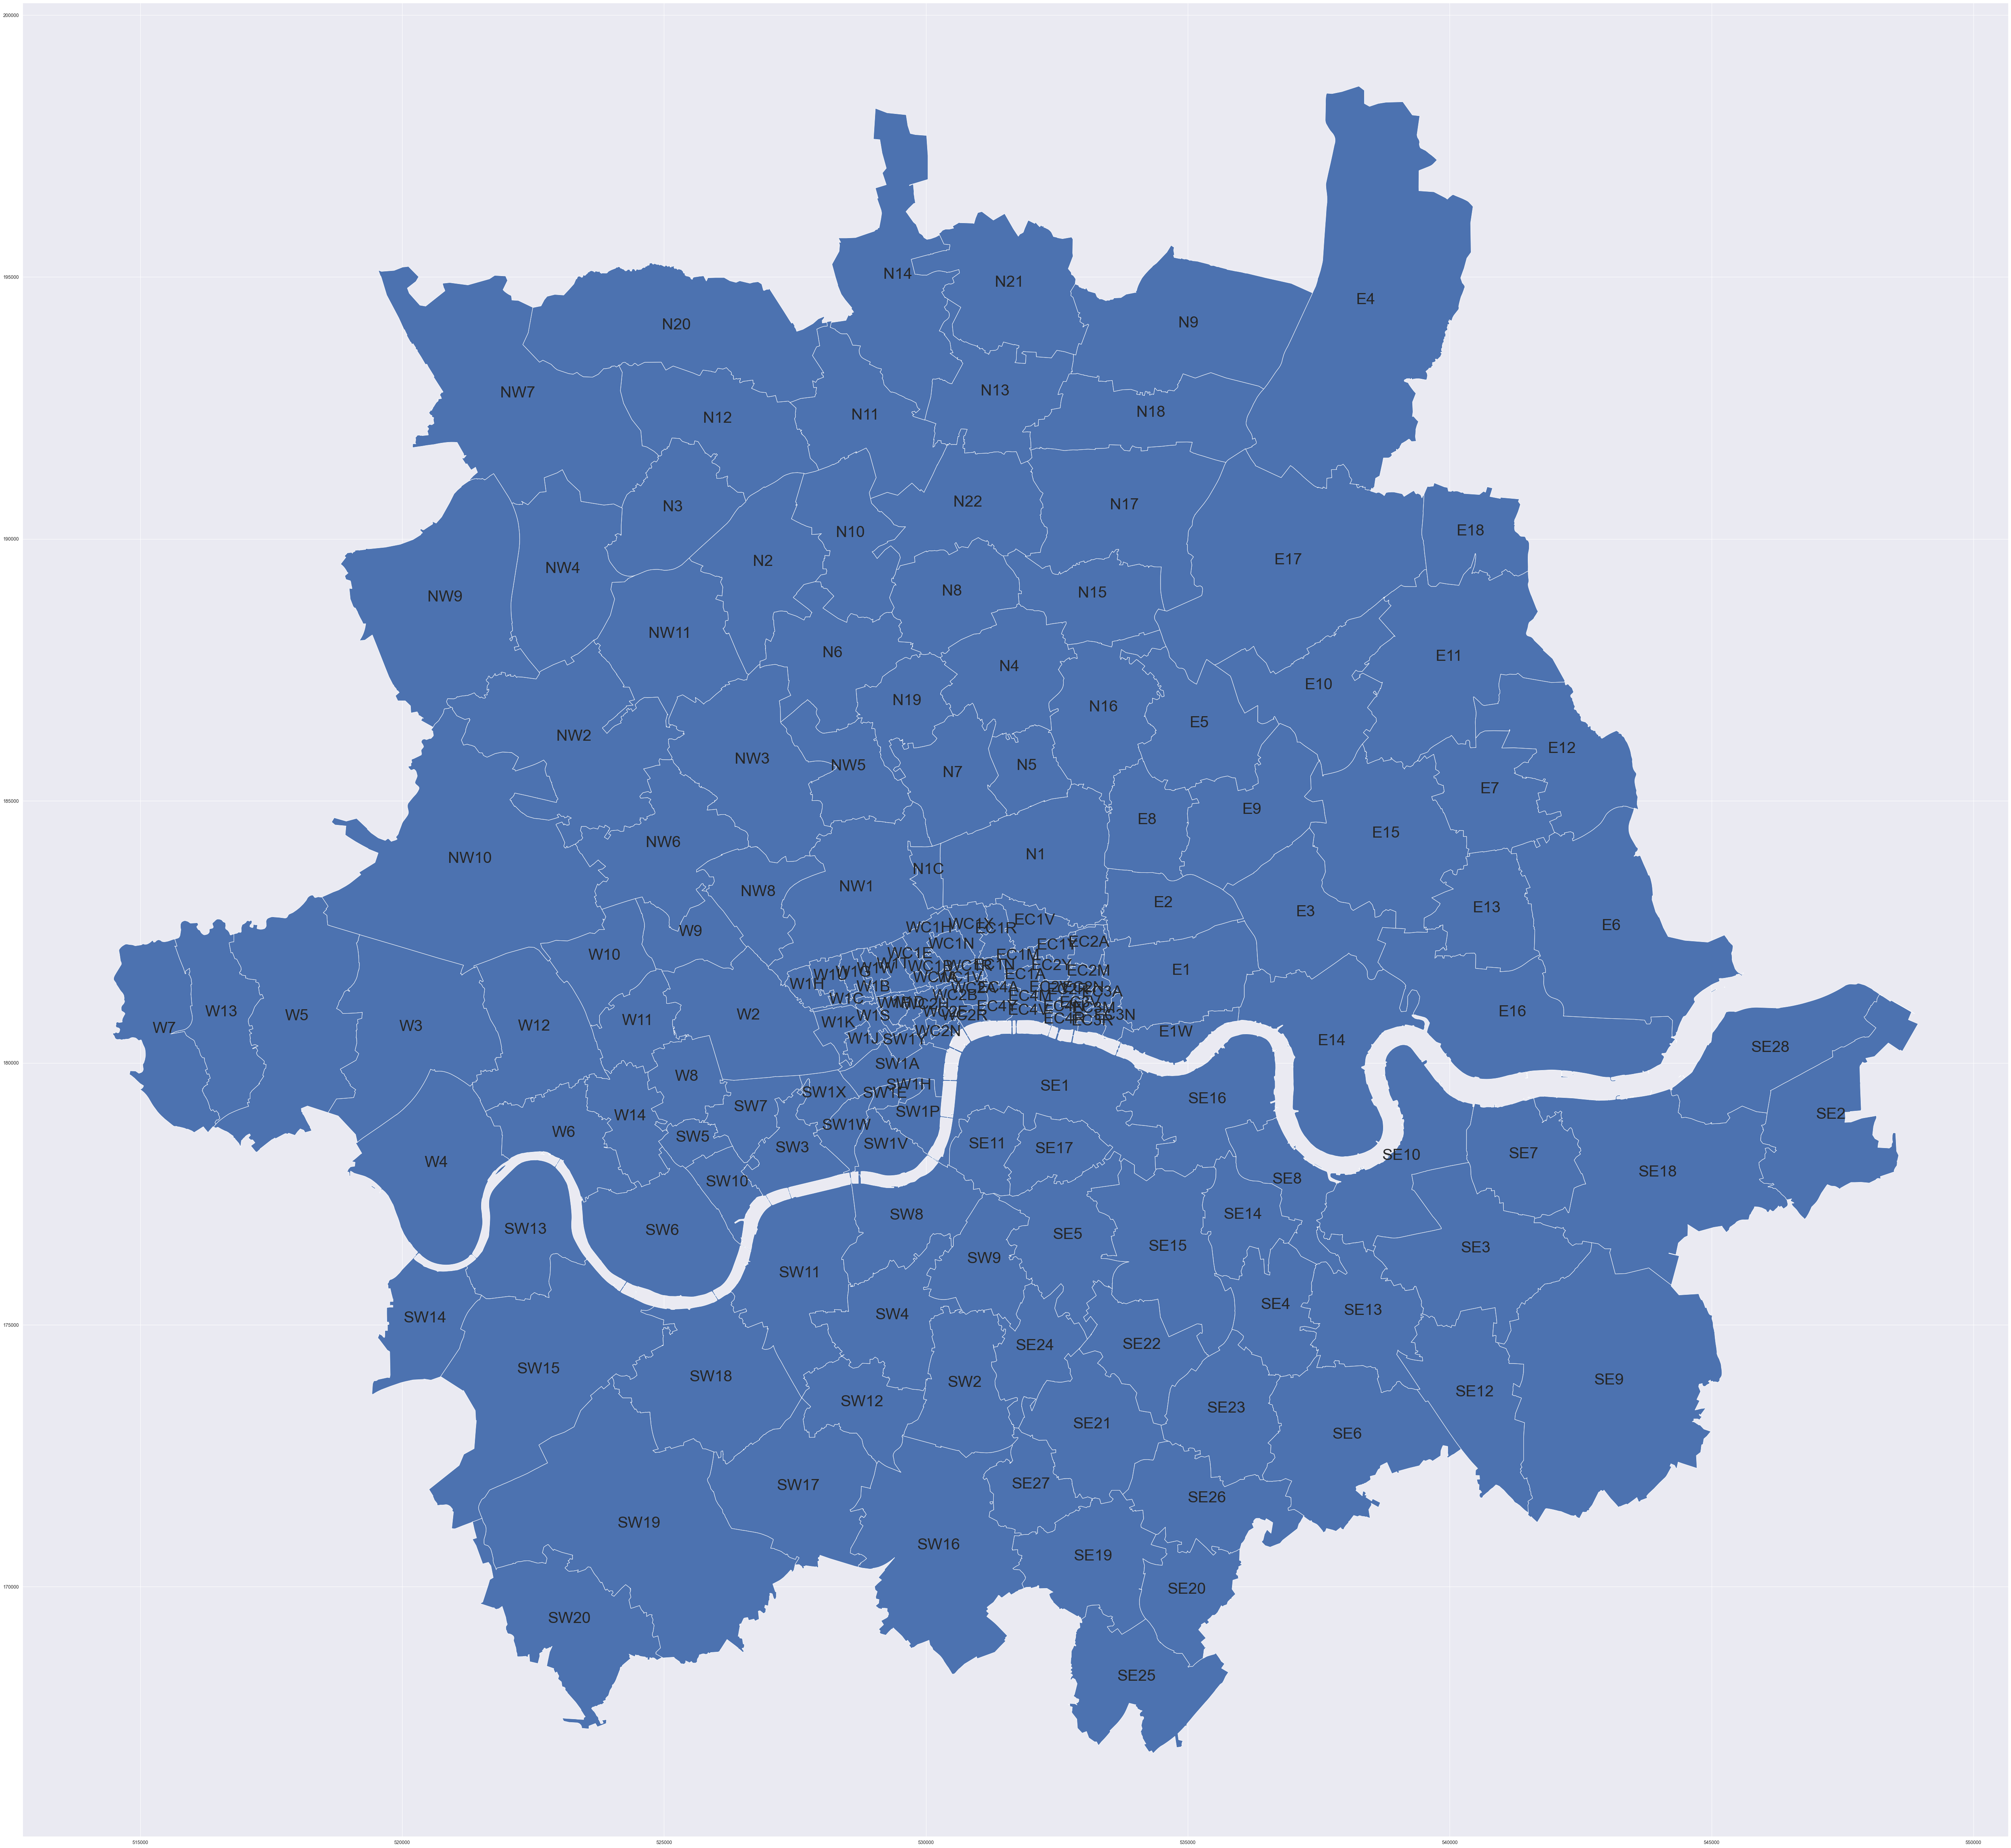

In [6]:
fig, ax =plt.subplots(figsize=(90,90))
London_PoD_df.plot(ax=ax)
London_PoD_df.apply(lambda x: ax.annotate(s=x['PostDist'], xy=x.geometry.centroid.coords[0], ha='center', size=40),axis=1)

In [47]:
dir_name = utils.path_to('src', 'data','GB_Postcodes')
file_name = 'PostalArea.shp'
file_path=os.path.join(dir_name,file_name)
GB_df=gpd.read_file(file_path)
GB_crs="EPSG:27700"
GB_df_proj=gpd.read_file(file_path).to_crs(final_crs)

C:\Users\vasan.churchill\AppData\Local\Continuum\anaconda3\envs\s2ds-trial\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [39]:
#Using the the regional filter to extract London Post Areas from GB Post Areas
GB_London_df = GB_df[GB_df['PostArea'].isin(['EC', 'WC', 'E', 'N', 'NW', 'SE', 'SW', 'W'])]
GB_London_df_proj = GB_df[GB_df['PostArea'].isin(['EC', 'WC', 'E', 'N', 'NW', 'SE', 'SW', 'W'])]

30      Annotation(538626, 186330, 'E')
31     Annotation(532332, 181742, 'EC')
67      Annotation(530343, 190679, 'N')
73     Annotation(523658, 186924, 'NW')
87     Annotation(538216, 175410, 'SE')
98     Annotation(526335, 173931, 'SW')
109     Annotation(521645, 180340, 'W')
111    Annotation(530404, 181745, 'WC')
dtype: object

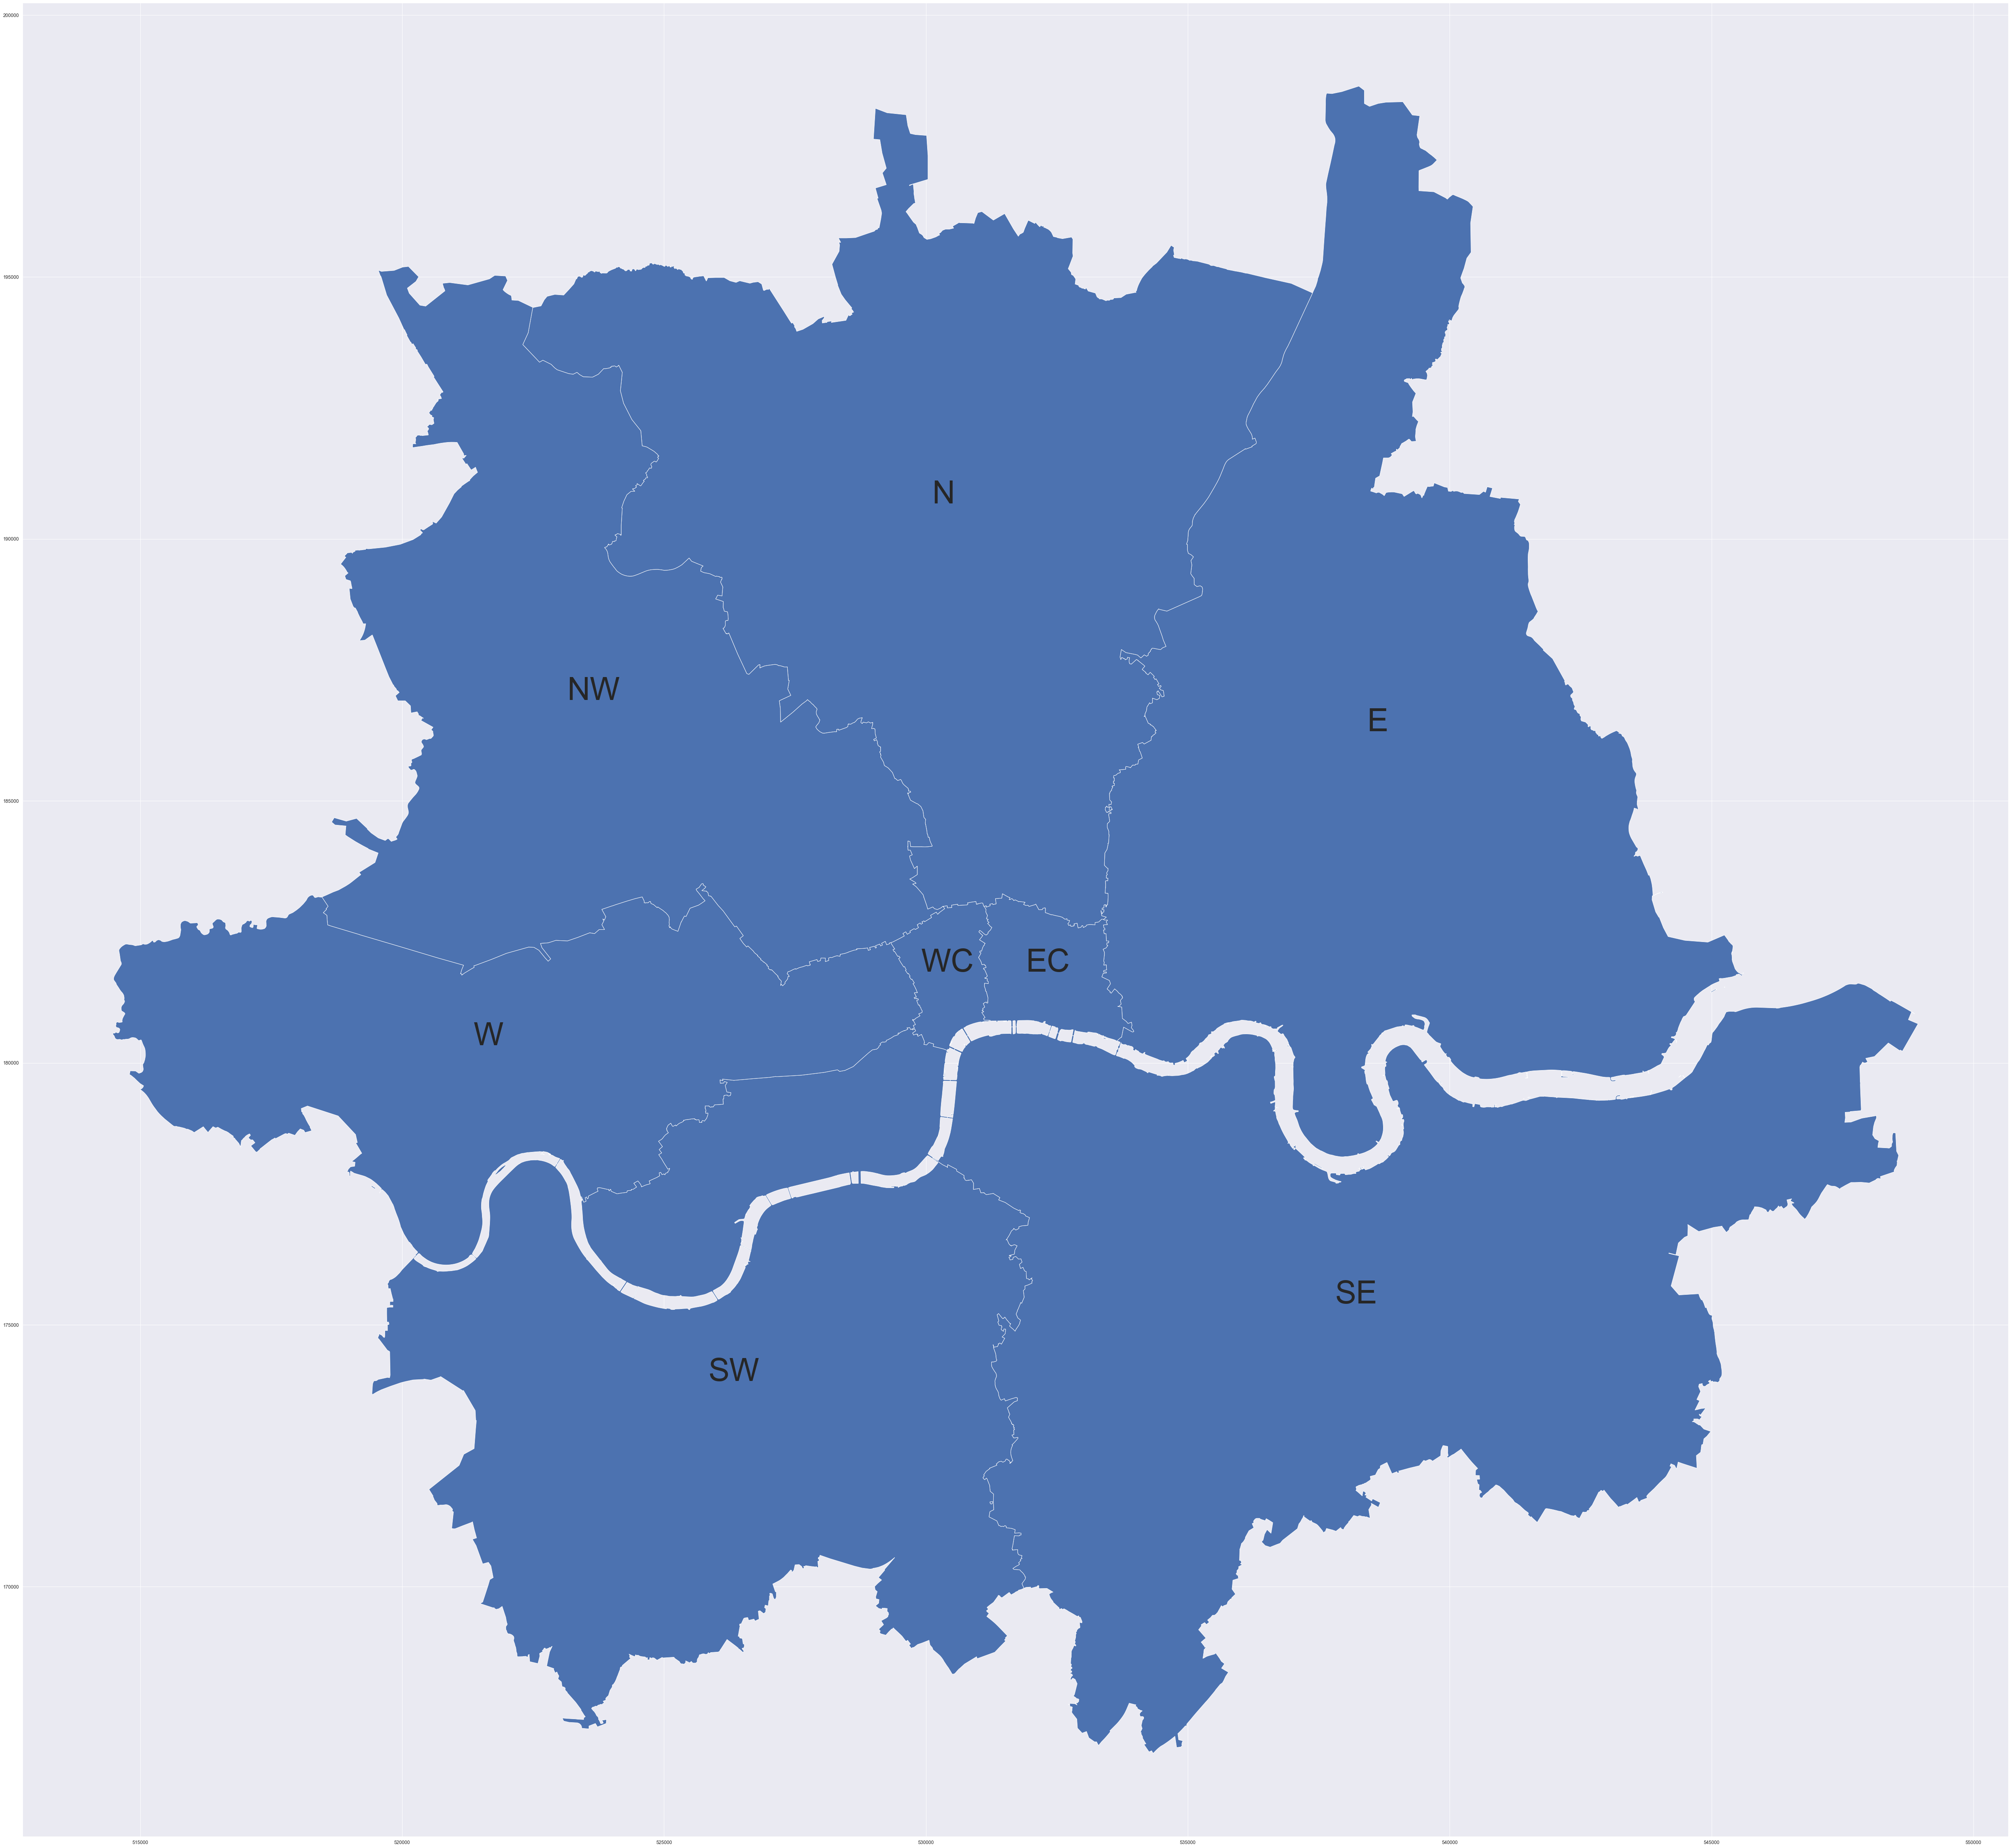

In [40]:
fig, ax =plt.subplots(figsize=(90,90))
GB_London_df.plot(ax=ax)
GB_London_df.apply(lambda x: ax.annotate(s=x['PostArea'], xy=x.geometry.centroid.coords[0], ha='center', size=80),axis=1)

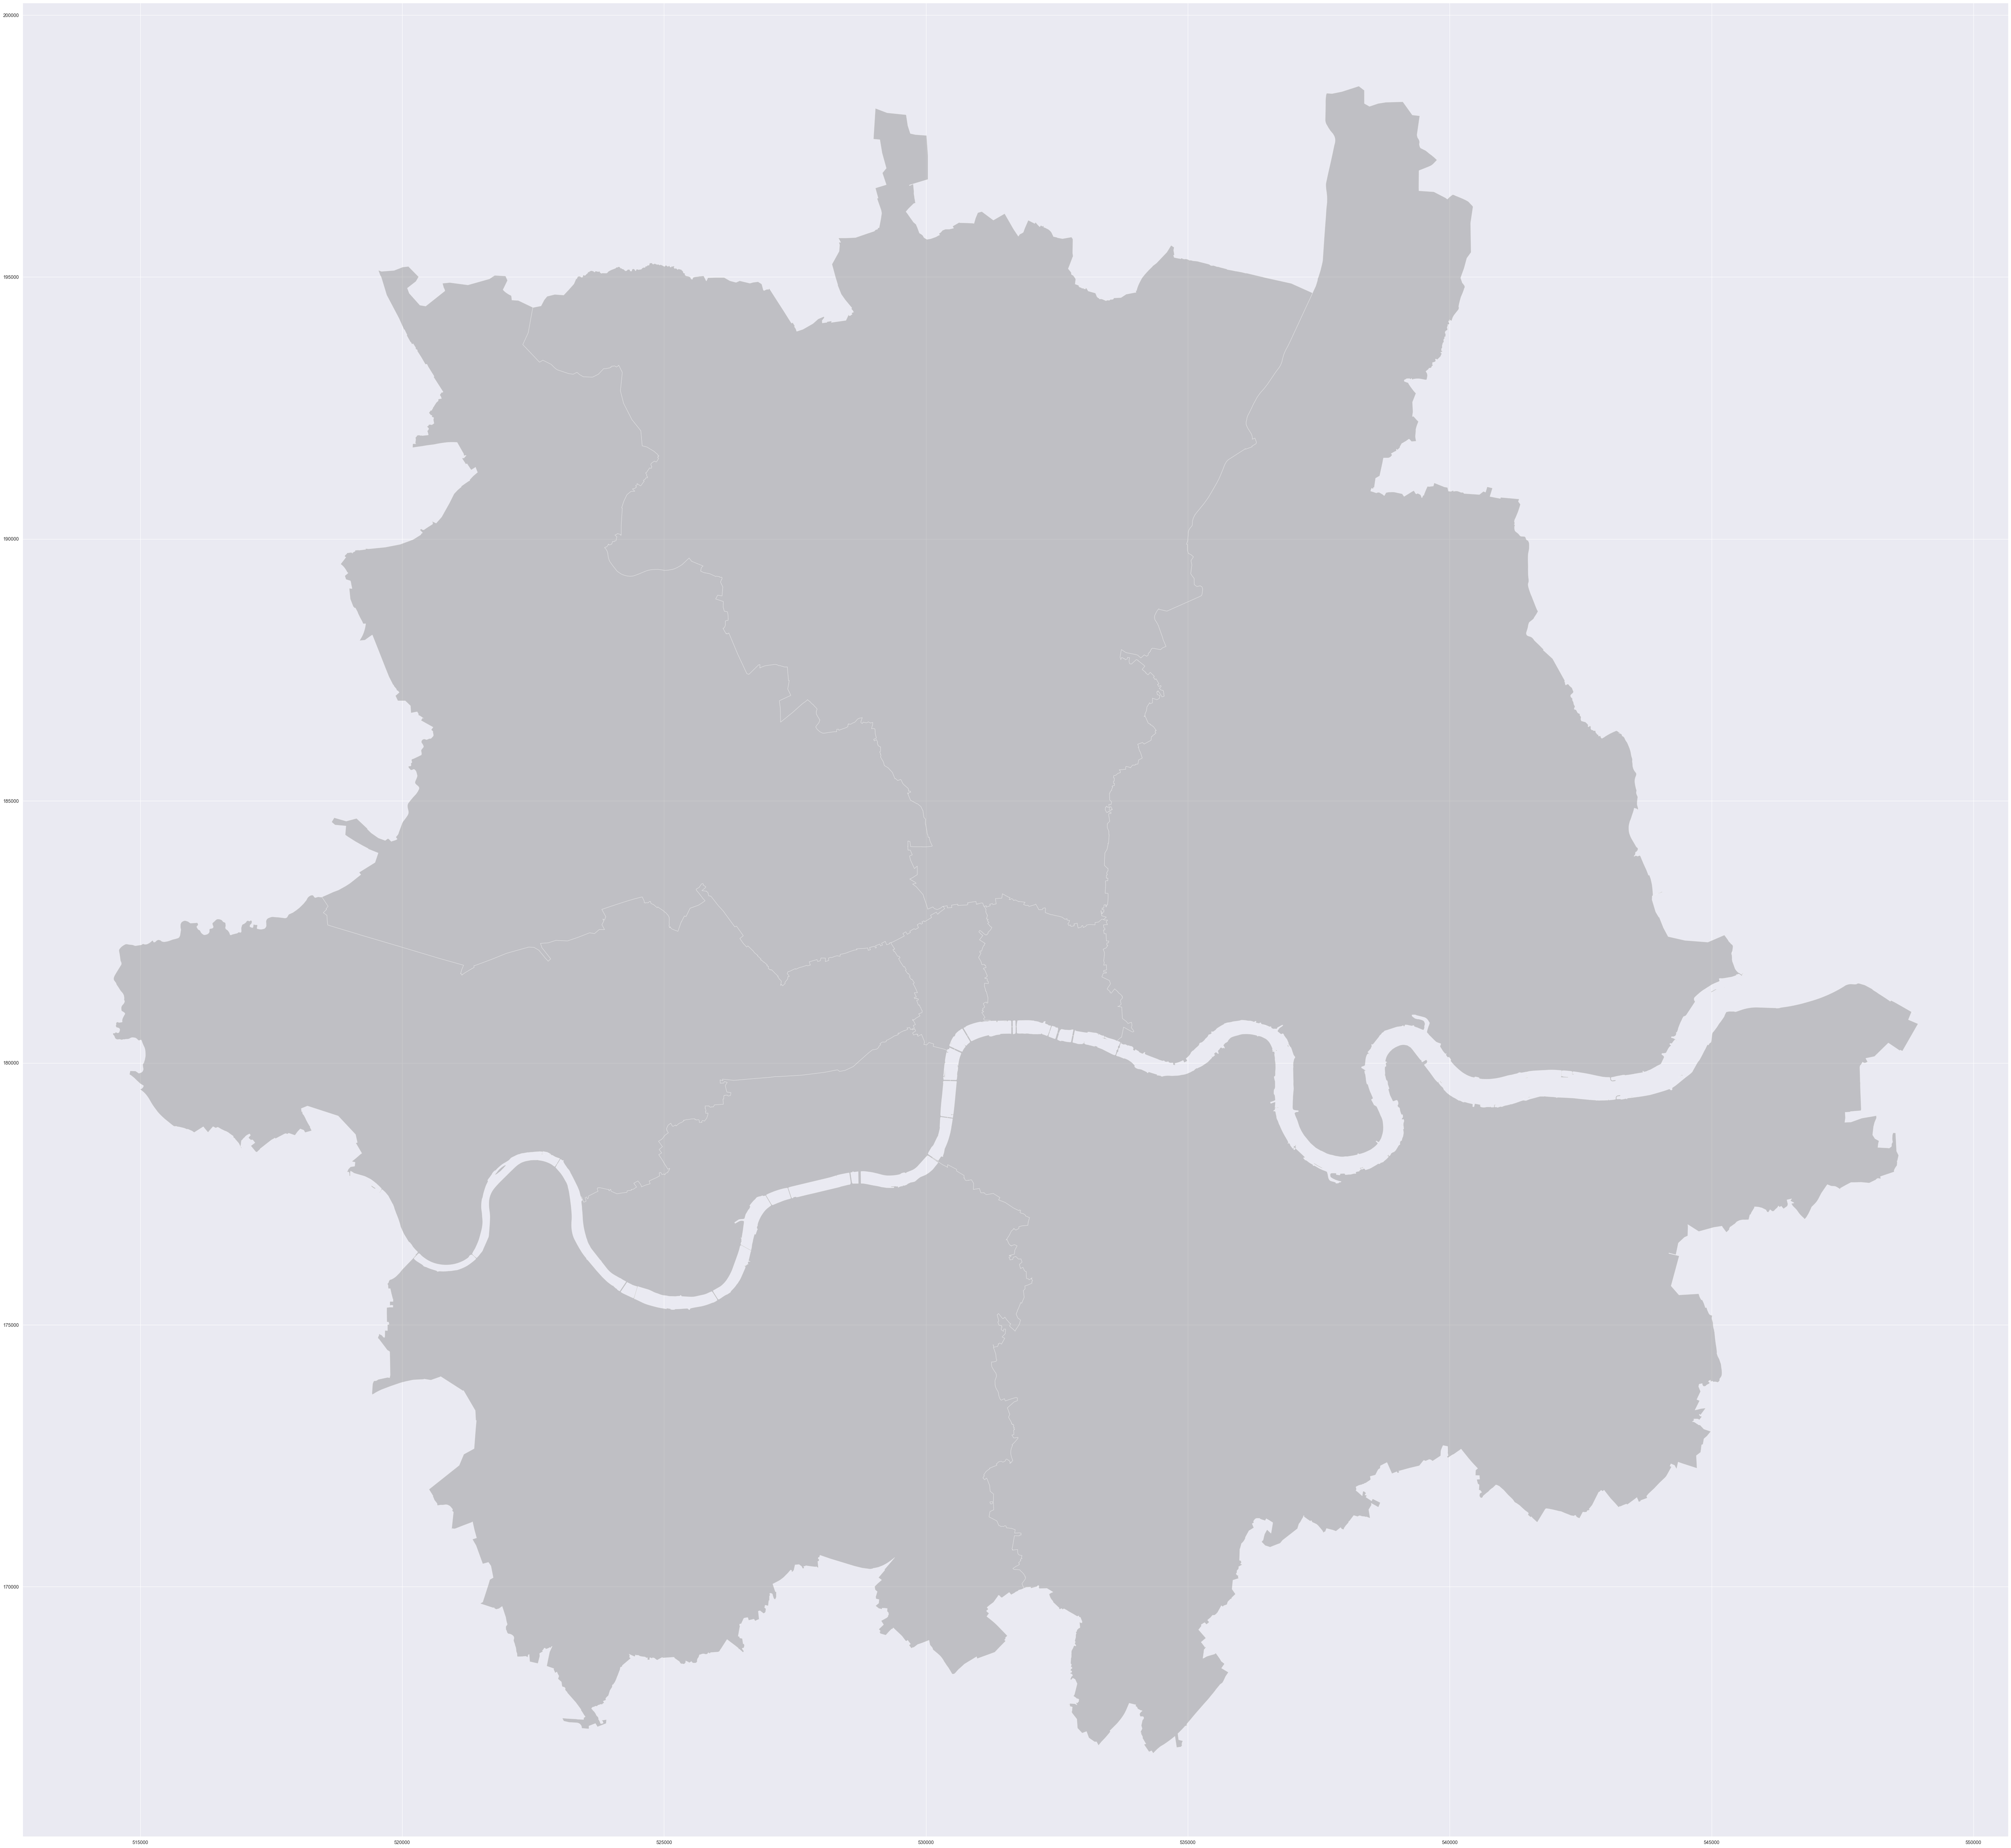

In [41]:
fig, ax =plt.subplots(figsize=(90,90))
GB_London_df_proj.plot(ax=ax,alpha=0.4, color="grey")

In [12]:
crs = {'init': 'epsg:4326'}

In [102]:
geometry = [Point(xy) for xy in zip(df['pickup_location_lng'], df['pickup_location_lat'])]
geometry[:3]

In [103]:
geo_df=gpd.GeoDataFrame(df, crs = crs, geometry = geometry )

In [104]:
geo_df.head()

job_id  status pickup_postcode  pickup_location_lat  pickup_location_lng  \
0  231558      99         SW3 4NX            51.489251            -0.164032   
1  231560      99         NW1 7JX            51.537842            -0.142225   
2  231561      99         NW1 7JX            51.537842            -0.142225   
3  231562      99         W1T 1BZ            51.518604            -0.132486   
4  231564      99         NW1 7JX            51.537842            -0.142225   

  delivery_postcode  delivery_location_lat  delivery_location_lng  distance  \
0           E20 1EJ              51.543535              -0.006004    16.328   
1            N7 7BY              51.553447              -0.108974     4.196   
2            W2 5AR              51.515672              -0.196826     5.834   
3           W12 7GF              51.508141              -0.219373     8.024   
4            W9 1HA              51.526377              -0.188469     4.776   

       insertion_date earliest_pickup_time   delivery_deadline  \
0 2018-01-01 11:22:47  2018-01-01 13:20:00 2018-01-01 16:00:00   
1 2018-01-01 12:01:37  2018-01-01 12:15:00 2018-01-01 13:00:00   
2 2018-01-01 12:03:34  2018-01-01 15:15:00 2018-01-01 16:00:00   
3 2018-01-01 13:04:13  2018-01-01 13:05:00 2018-01-01 14:45:00   
4 2018-01-01 13:43:45  2018-01-01 16:15:00 2018-01-01 17:00:00   

          date_booked        date_started  vehicle_type  \
0 2018-01-01 13:16:12 2018-01-01 13:16:16            20   
1 2018-01-01 12:02:38 2018-01-01 12:02:46            20   
2 2018-01-01 12:03:35 2018-01-01 14:45:07            15   
3 2018-01-01 13:07:01 2018-01-01 13:07:07            20   
4 2018-01-01 13:43:46 2018-01-01 15:45:07            20   

   courier_money_earned_net  is_first_war_job  job_priority  riskiness  \
0                     29.42                 0             1          0   
1                      9.08                 0             0          0   
2                     10.60                 0             2          0   
3                     18.21                 0             1          0   
4                      4.99                 0             2          0   

   show_on_board  size_x  size_y  size_z  weight  special_care  is_food  \
0              0    35.0    25.0     2.5    0.10             1        0   
1              0    40.0    30.0    20.0    9.00             1       99   
2              0    40.0    30.0    20.0   17.60             1        0   
3              0    25.0    16.5     0.5    0.75             0        0   
4              0    40.0    30.0    20.0    4.80             1        0   

   is_fragile  is_liquid  is_not_rotatable  is_glass  ...  \
0           1          0                 0         0  ...   
1          99         99                99         1  ...   
2           0         99                99         1  ...   
3           0          0                 0         0  ...   
4           0         99                99         1  ...   

   earliest_pickup_time_hour_11  earliest_pickup_time_hour_12  \
0                             0                             0   
1                             0                             1   
2                             0                             0   
3                             0                             0   
4                             0                             0   

   earliest_pickup_time_hour_13  earliest_pickup_time_hour_14  \
0                             1                             0   
1                             0                             0   
2                             0                             0   
3                             1                             0   
4                             0                             0   

   earliest_pickup_time_hour_15  earliest_pickup_time_hour_16  \
0                             0                             0   
1                             0                             0   
2                             1                             0

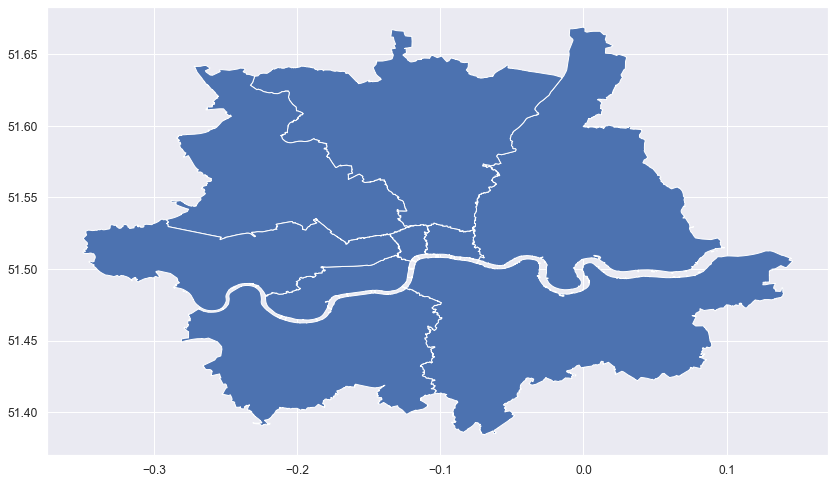

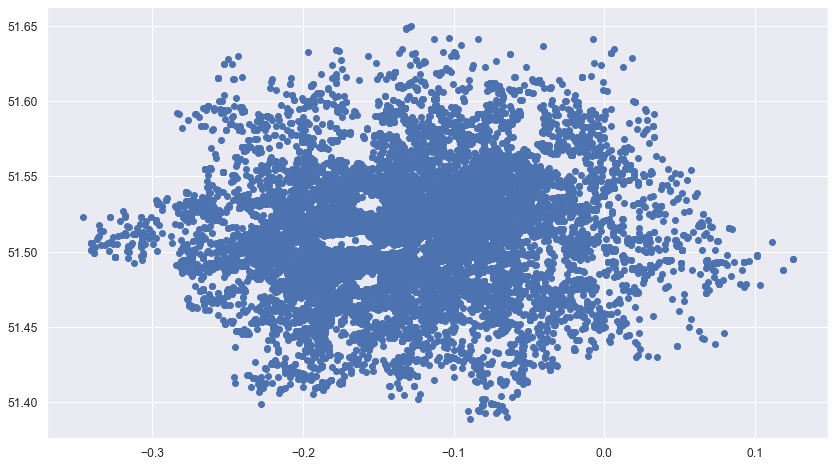

In [105]:
#fig, ax =plt.subplots(figsize=(20,20))
lat_crs = "epsg:4326"
GB_London_df.plot()
#GB_London_df.plot(ax=ax)
#dfm = df.loc[(df.rejected_count <= 30) & (df.rejected_count > 0),['pickup_location_lat','pickup_location_lng','rejected_count']]
#geo_df[geo_df[]]
#geo_df.loc[(geo_df.rejected_count <= 30) & (geo_df.rejected_count > 0), ['pickup_location_lat','pickup_location_lng','rejected_count','geometry']].to_crs(final_crs).plot(ax=ax, markersize = 20, color="blue")
geo_df.plot()
#geo_df.plot(ax=ax,markersize=20,color='red',alpha=0.4)

In [93]:
GB_London_df.crs #get the current coordinate reference system

<Projected CRS: PROJCS["Transverse_Mercator",GEOGCS["GCS_Airy 1830 ...>
Name: Transverse_Mercator
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: D_unknown
- Ellipsoid: airy
- Prime Meridian: Greenwich

In [96]:
GB_London_df=GB_London_df.to_crs("EPSG:4326") # EPSG 4326 is the correct code for lat long

In [97]:
GB_London_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

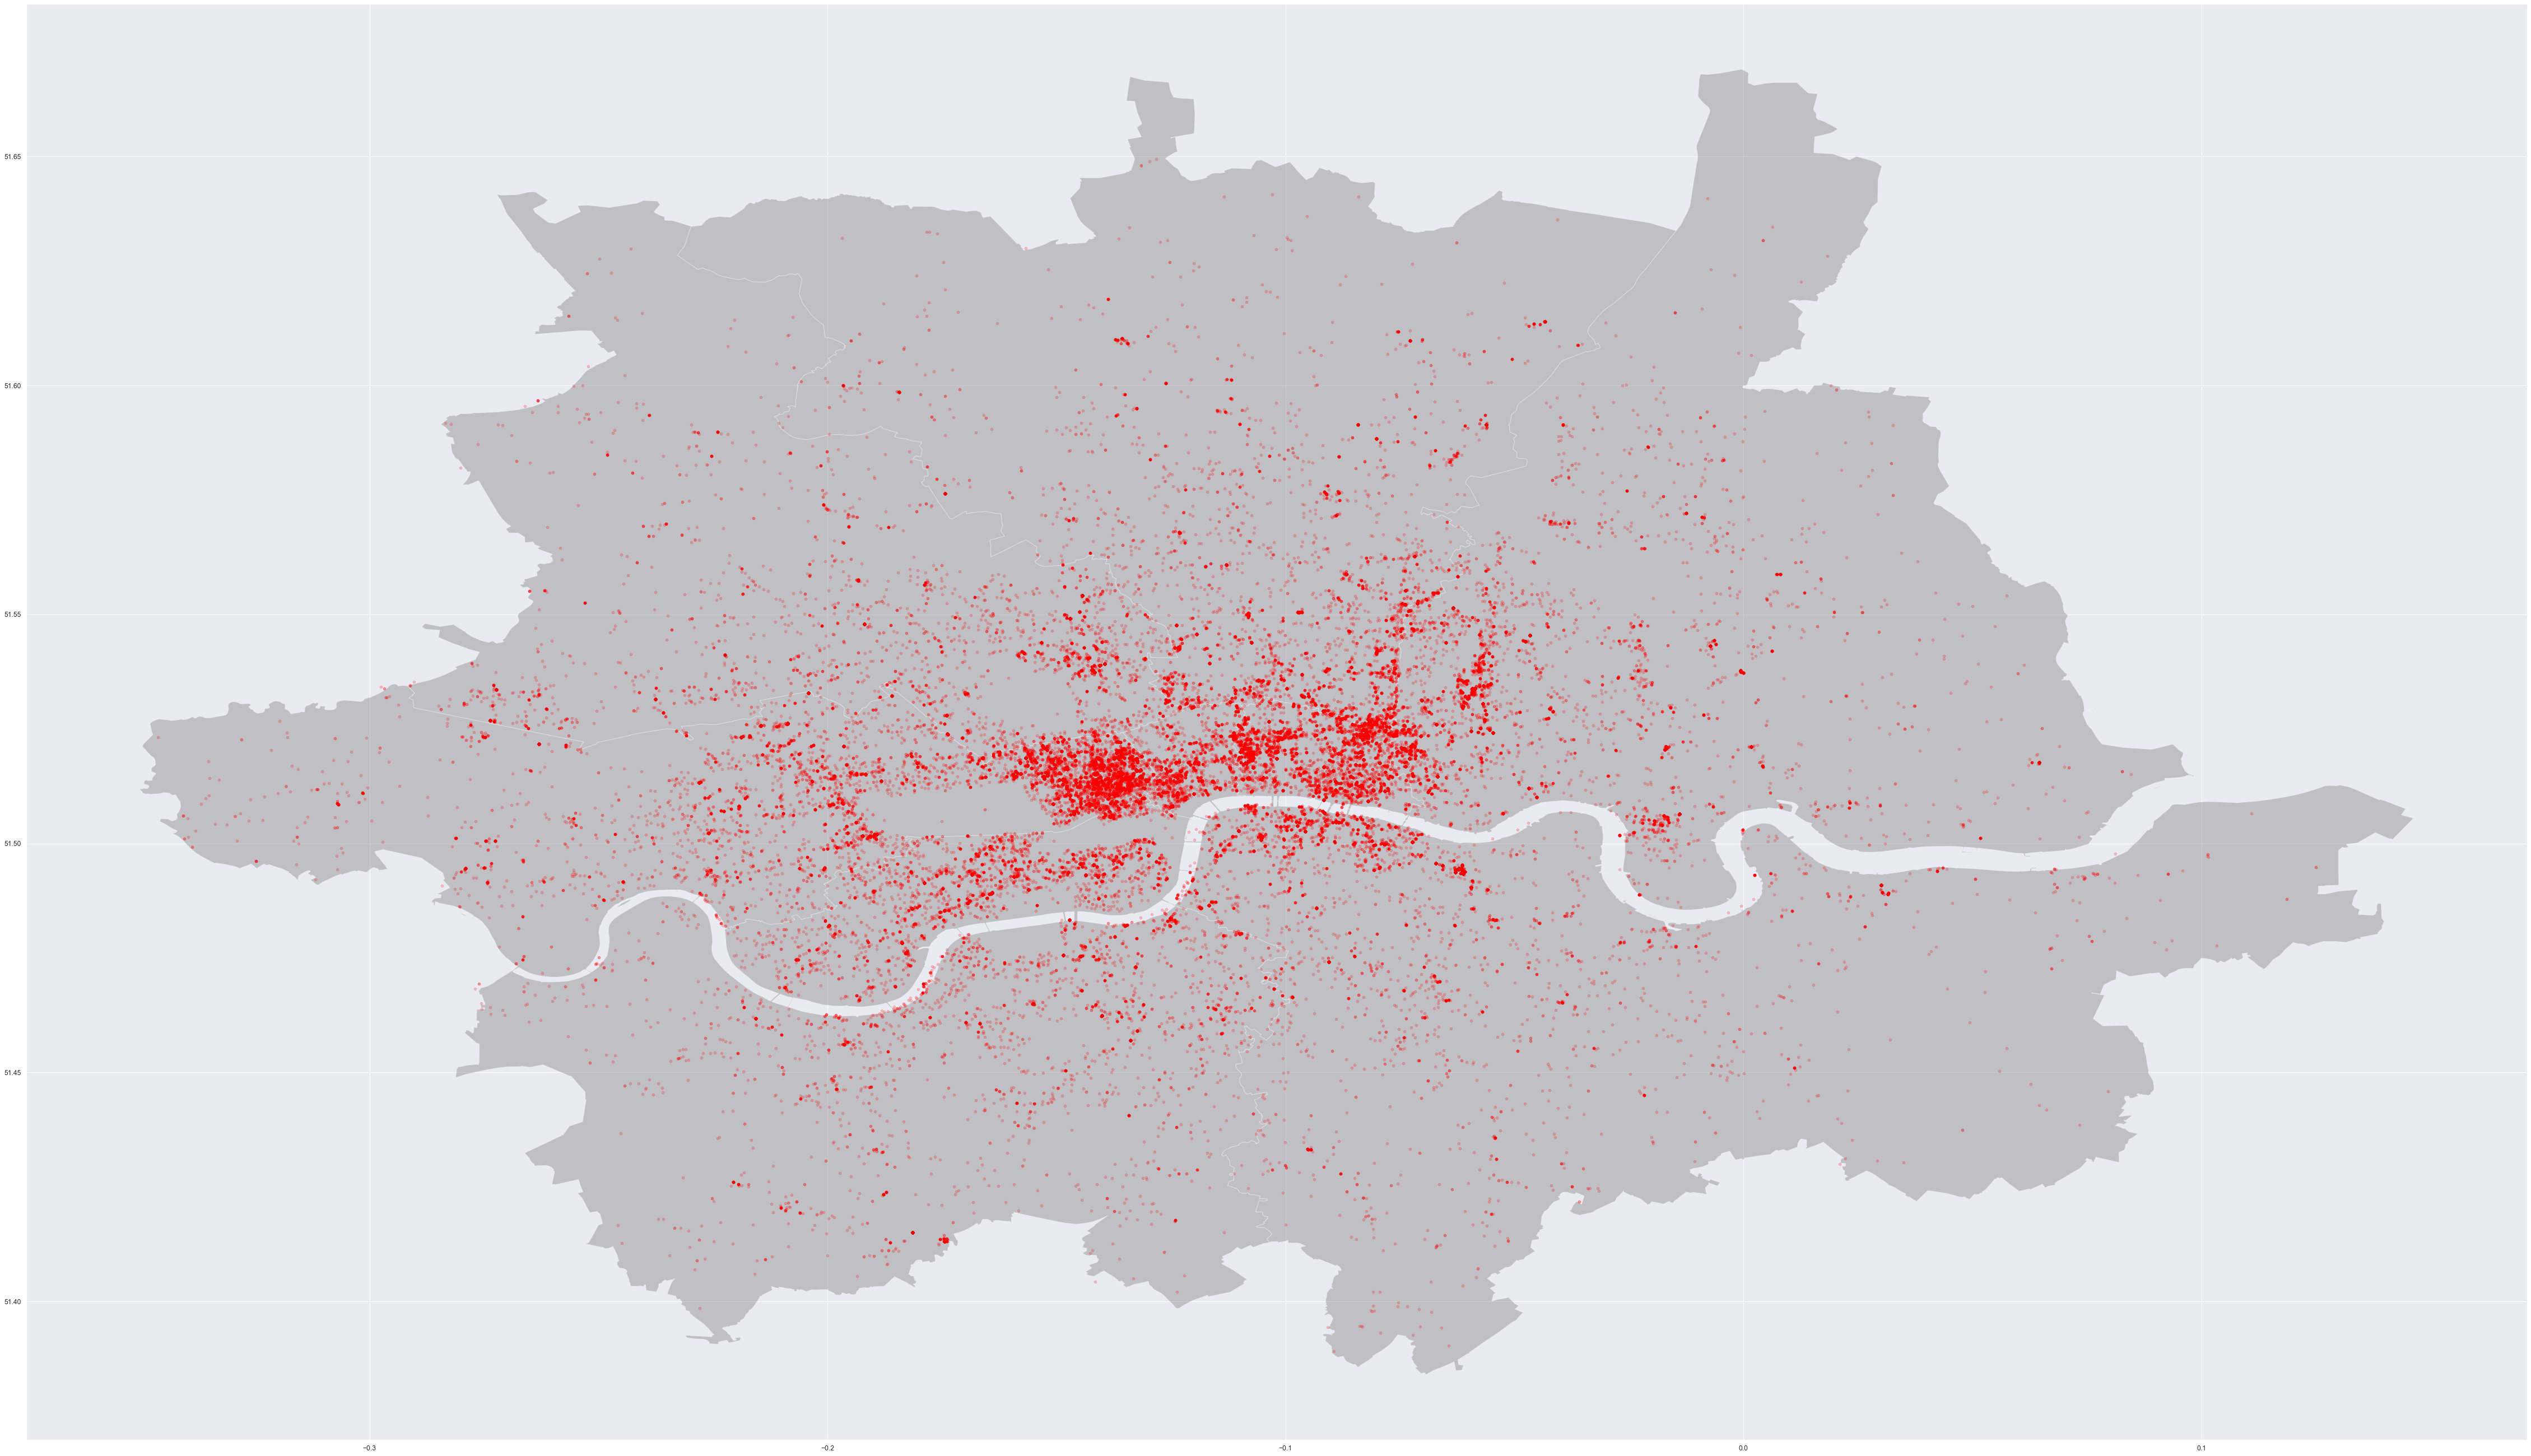

In [112]:
fig, ax =plt.subplots(figsize=(80,80))
GB_London_df.plot(ax=ax, color = "grey", alpha=0.4)
geo_df.plot(ax=ax,markersize=20,color='red',alpha=0.2)